# Idea de la figura

Mostrar como la colaboración con una persona super-citada tiene un efecto en tu carrera a corto y largo plazo.

El estudio es para el periodo 1990--2019 y se hará por género.

La tabla principal debe tener, para cada autor y año, donde el año 0 es el año de colaboración con un super citado:

 - Número de citas recibidas
 - Número de artículos publicados

Además, necesitamos el género del autor.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [3]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [4]:
# Female, male
colors = ['#5175bc', '#d23a47']

In [5]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

# Load tables

In [6]:
cite = pd.read_csv('../../data/processed/cites_2.csv')

In [7]:
colab = pd.read_csv('../../data/processed/co_author_2.csv')

In [8]:
article = pd.read_csv('../../data/econometry/base_1_todos.csv')

In [9]:
colab = colab[colab.year.between(1990, 2019)]

## Super cited

In [10]:
years = []
super_cited = []
for year in [2000, 2003] + list(range(2005, 2020)):
    years.append(year)
    if year == 2000:
        chunk = cite[cite.s_year <= year]
    elif year == 2003:
        chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003)]
    elif year == 2005:
        chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005)]
    else:
        chunk = cite[cite.s_year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="source",
                                     target="target",
                                     create_using=nx.DiGraph)
    degree = pd.DataFrame(G_year.in_degree(), columns=["author", "degree"])
    mu = degree.degree.mean()
    r = degree.degree.quantile(.75) - degree.degree.quantile(.25)
    scited = degree[degree.degree >= mu + 1.5 * r].author.unique()
    super_cited.append(set(scited))

In [11]:
cauthors = set(cite.target.unique())
aauthors = set(article['Short-Id'].unique())
coauthors = set(colab.author1.unique()) | set(colab.author2.unique())

In [12]:
three = cauthors & aauthors & coauthors

In [13]:
data = []
years = []
neighbors = []
for i, year in enumerate([2000, 2003] + list(range(2005, 2020))):
    if year == 2000:
        chunk = cite[cite.s_year <= year]
    elif year == 2003:
        chunk = cite[(cite.s_year > 2000) & (cite.s_year <= 2003)]
    elif year == 2005:
        chunk = cite[(cite.s_year > 2003) & (cite.s_year <= 2005)]
    else:
        chunk = cite[cite.s_year == year]
    G_year = nx.from_pandas_edgelist(chunk,
                                     source="source",
                                     target="target",
                                     create_using=nx.DiGraph)
    n = []
    for sc in super_cited[i]:
        if sc in G_year:
            n.extend(list(G_year[sc]))
    n = set(n)
    if i == 0:
        n = n - super_cited[i]
    else:
        for j in range(0, i+1):
            n = n - super_cited[j]
    neighbors.append(n)
    years.append(year)

In [14]:
first = dict()
for i, batch in enumerate(neighbors):
    for n in batch:
        if n not in first:
            first[n] = years[i]

In [15]:
df = pd.DataFrame(first.items(), columns=['author', 'year_colab'])

In [16]:
app = article.groupby('Short-Id').year.first().rename('first_article').reset_index().rename(columns={'Short-Id': 'author'})

In [17]:
df = pd.merge(df, app, how='left')

In [18]:
df = df[df.year_colab >= df.first_article]

## Add cites per year

Podemos saltarnos esta parte.

In [19]:
data = []
for i, author in enumerate(first):
    chunk = cite[cite.target==author]
    line = [author]
    y = first[author]
    array = np.empty(21,)
    array[:] = np.nan
    for j, year in enumerate(range(y - 10, y + 11)):
        c = chunk[(chunk.s_year == year)].shape[0]
        if c != 0:
            array[j] = c
    line.extend(list(array))
    data.append(line)
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


In [21]:
df_2 = pd.DataFrame(data, columns=['author'] + [f't{x}' for x in range(-10, 11)])

In [22]:
df_2.to_csv('../../data/evolution_cites.csv', index=False)

In [23]:
df_melt = pd.melt(df_2, id_vars='author')

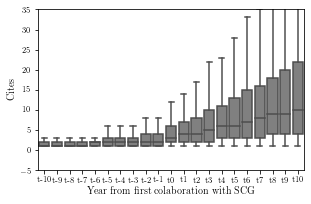

In [24]:
width = 345
fig, ax = plt.subplots(1, 1, figsize=set_size(width, fraction=1))

g = sns.boxplot(x='variable', y='value', data=df_melt, fliersize=0, color='gray', ax=ax)
g.set_ylim(-5, 35)
g.set_ylabel('Cites')
g.set_xlabel('Year from first colaboration with SCG');
fig.savefig('../../figures/evol_colab_scg.pdf')

In [25]:
data_2 = []
for i, author in enumerate(first):
    chunk = article[article['Short-Id']==author]
    line = [author]
    y = first[author]
    array = np.empty(21,)
    array[:] = np.nan
    for j, year in enumerate(range(y - 10, y + 11)):
        c = chunk[(chunk.year == year)].shape[0]
        if c != 0:
            array[j] = c
    line.extend(list(array))
    data_2.append(line)
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


In [26]:
df_3 = pd.DataFrame(data_2, columns=['author'] + [f't{x}' for x in range(-10, 11)])

In [27]:
df_3.to_csv('../../data/evolution_articles.csv', index=False)

In [28]:
df_melt = pd.melt(df_3, id_vars='author')

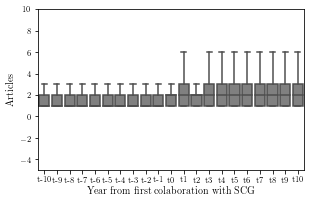

In [29]:
width = 345
fig, ax = plt.subplots(1, 1, figsize=set_size(width, fraction=1))

g = sns.boxplot(x='variable', y='value', data=df_melt, fliersize=0, color='gray', ax=ax)
g.set_ylim(-5, 10)
g.set_ylabel('Articles')
g.set_xlabel('Year from first colaboration with SCG');
fig.savefig('../../figures/evol_colab_scg_articles.pdf')